In [10]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox
from precision_recall_cutoff import precision_recall_cutoff

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [11]:
# changing sales and salary dummies
turnover = pd.concat([turnover.drop(columns = ['sales', 'salary'], axis =  1 ), pd.get_dummies(turnover[['sales', 'salary']])], axis = 1)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.478\nsamples = 3354\nvalue = [1327, 2027]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.21\nsamples = 1387\nvalue = [165, 1222]'),
 Text(0.0625, 0.125, 'gini = 0.099\nsamples = 1282\nvalue = [67, 1215]'),
 Text(0.1875, 0.125, 'gini = 0.124\nsamples = 105\nvalue = [98, 7]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.484\nsamples = 1967\nvalue = [1162, 805]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 713\nvalue = [0, 713]'),
 Text(0.4375, 0.125, 'gini = 0.136\nsamples = 1254\nvalue = [1162, 92]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.174\nsamples = 8645\nvalue = [7815, 830]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.5\ngini = 0.03\nsamples = 7064\nvalue = [6958, 106]'),
 Text(0.5625, 0.125, 'gini = 0.027\nsamples = 7056\nvalue = [6958, 98]'),
 Text(0.6875, 0.125, 'gini = 0.0\

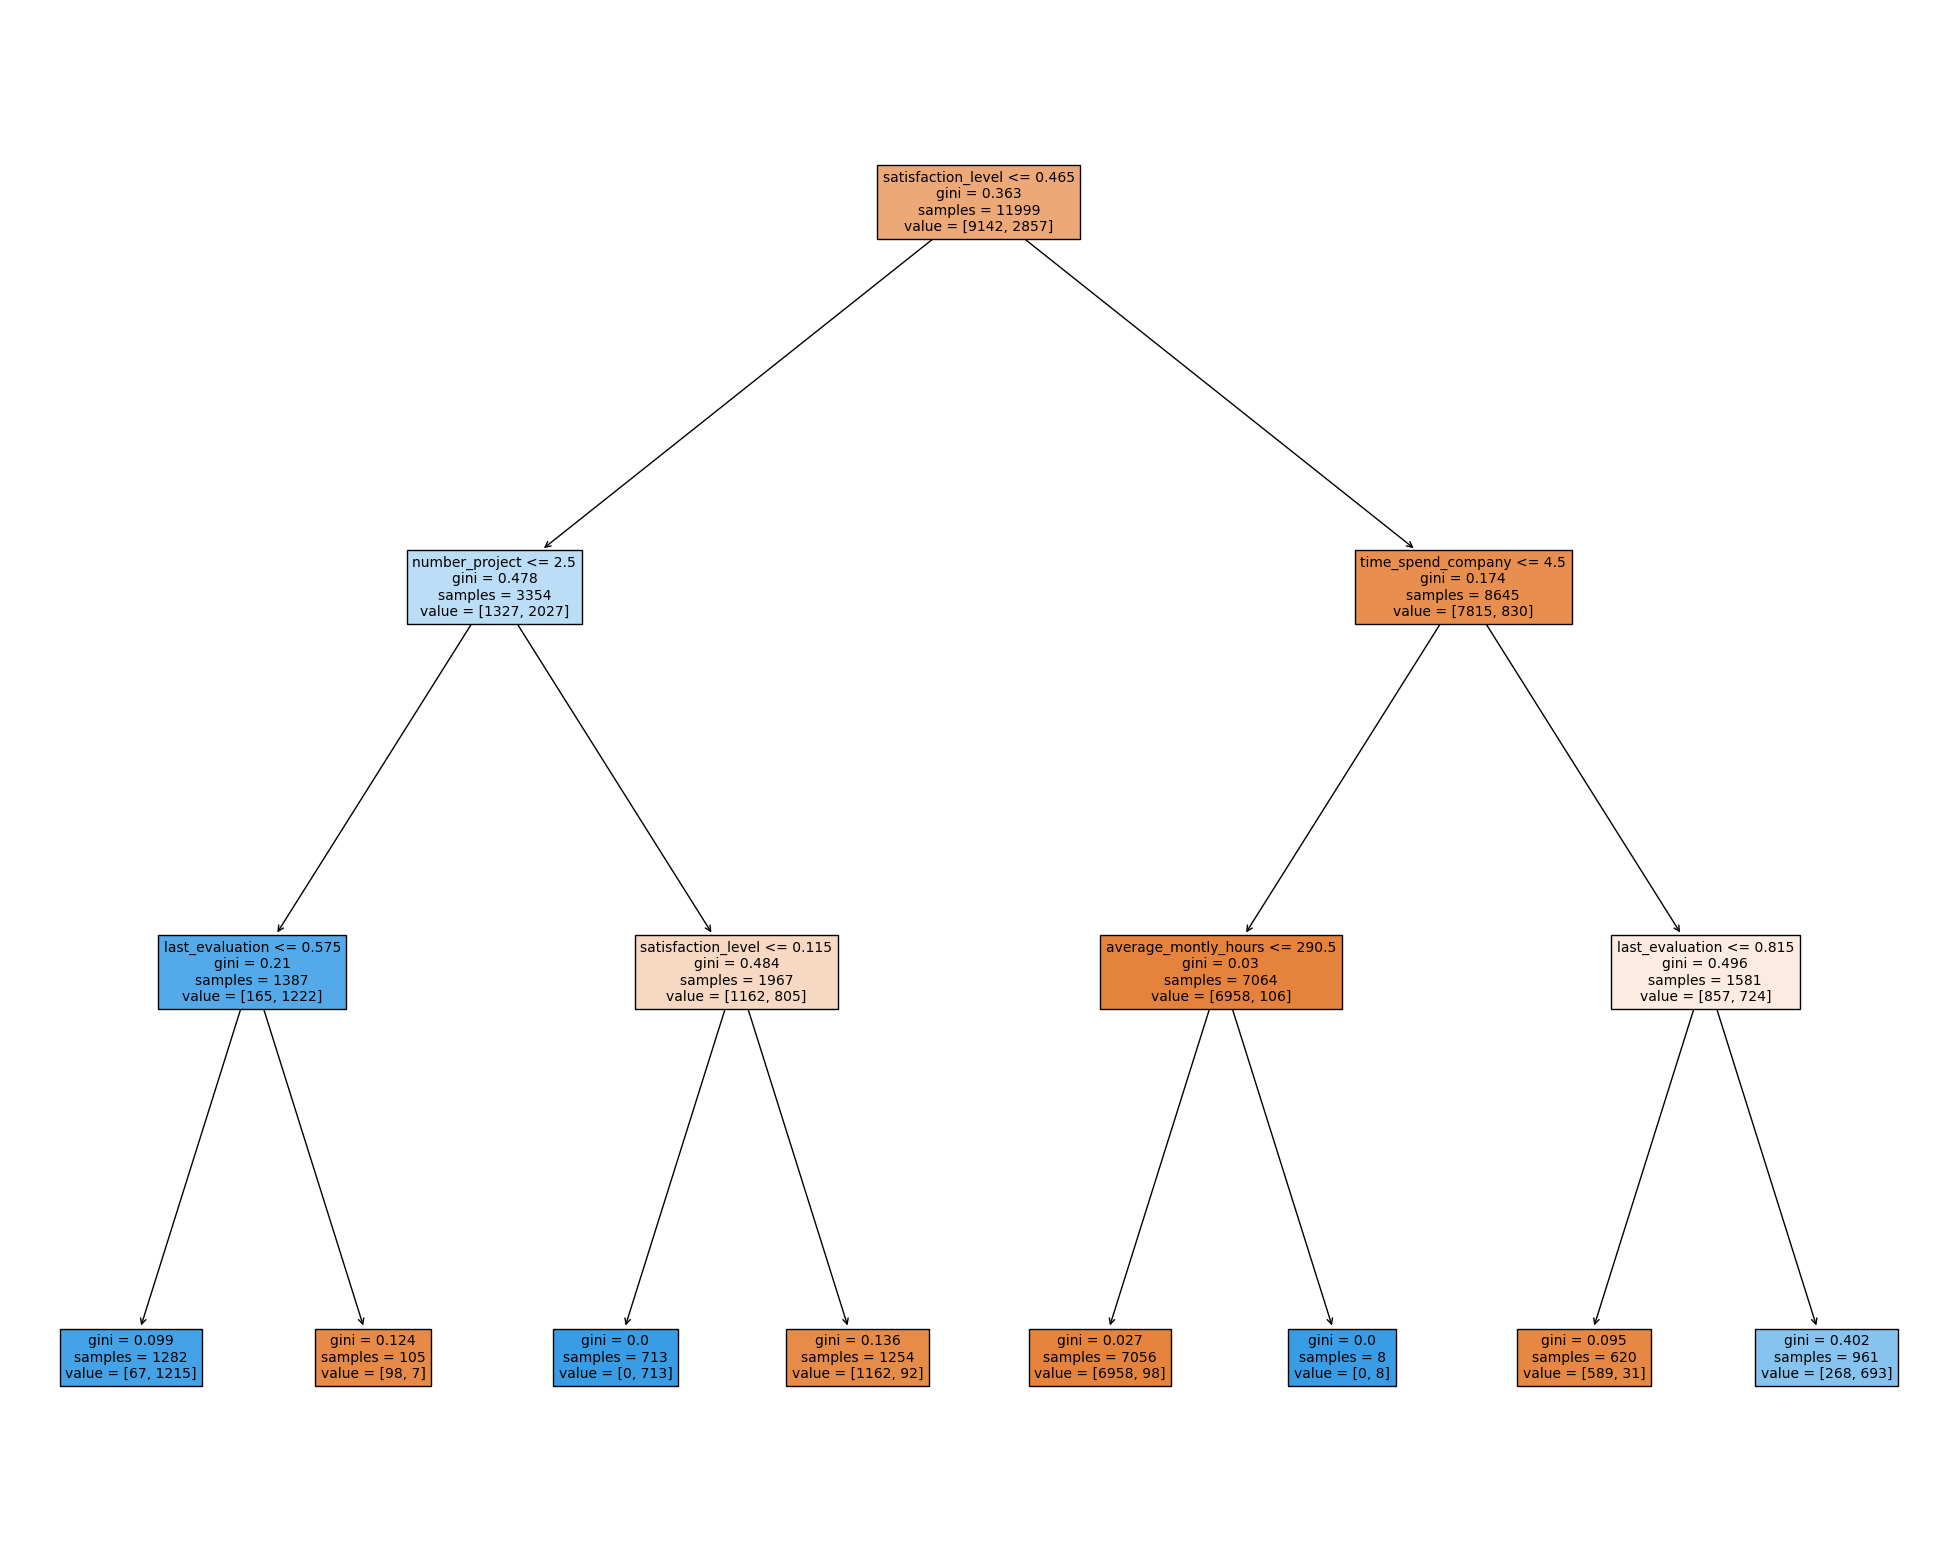

In [15]:
# defining imput and target
x = turnover.drop(columns = 'left', axis = 1)
y = turnover['left']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.479\nsamples = 3378\nvalue = [1345, 2033]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.216\nsamples = 1407\nvalue = [173, 1234]'),
 Text(0.0625, 0.125, 'gini = 0.105\nsamples = 1299\nvalue = [72, 1227]'),
 Text(0.1875, 0.125, 'gini = 0.121\nsamples = 108\nvalue = [101, 7]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.482\nsamples = 1971\nvalue = [1172, 799]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 708\nvalue = [0, 708]'),
 Text(0.4375, 0.125, 'gini = 0.134\nsamples = 1263\nvalue = [1172, 91]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.173\nsamples = 8621\nvalue = [7797, 824]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.5\ngini = 0.027\nsamples = 7035\nvalue = [6940, 95]'),
 Text(0.5625, 0.125, 'gini = 0.025\nsamples = 7028\nvalue = [6940, 88]'),
 Text(0.6875, 0.125, 'gini = 0.

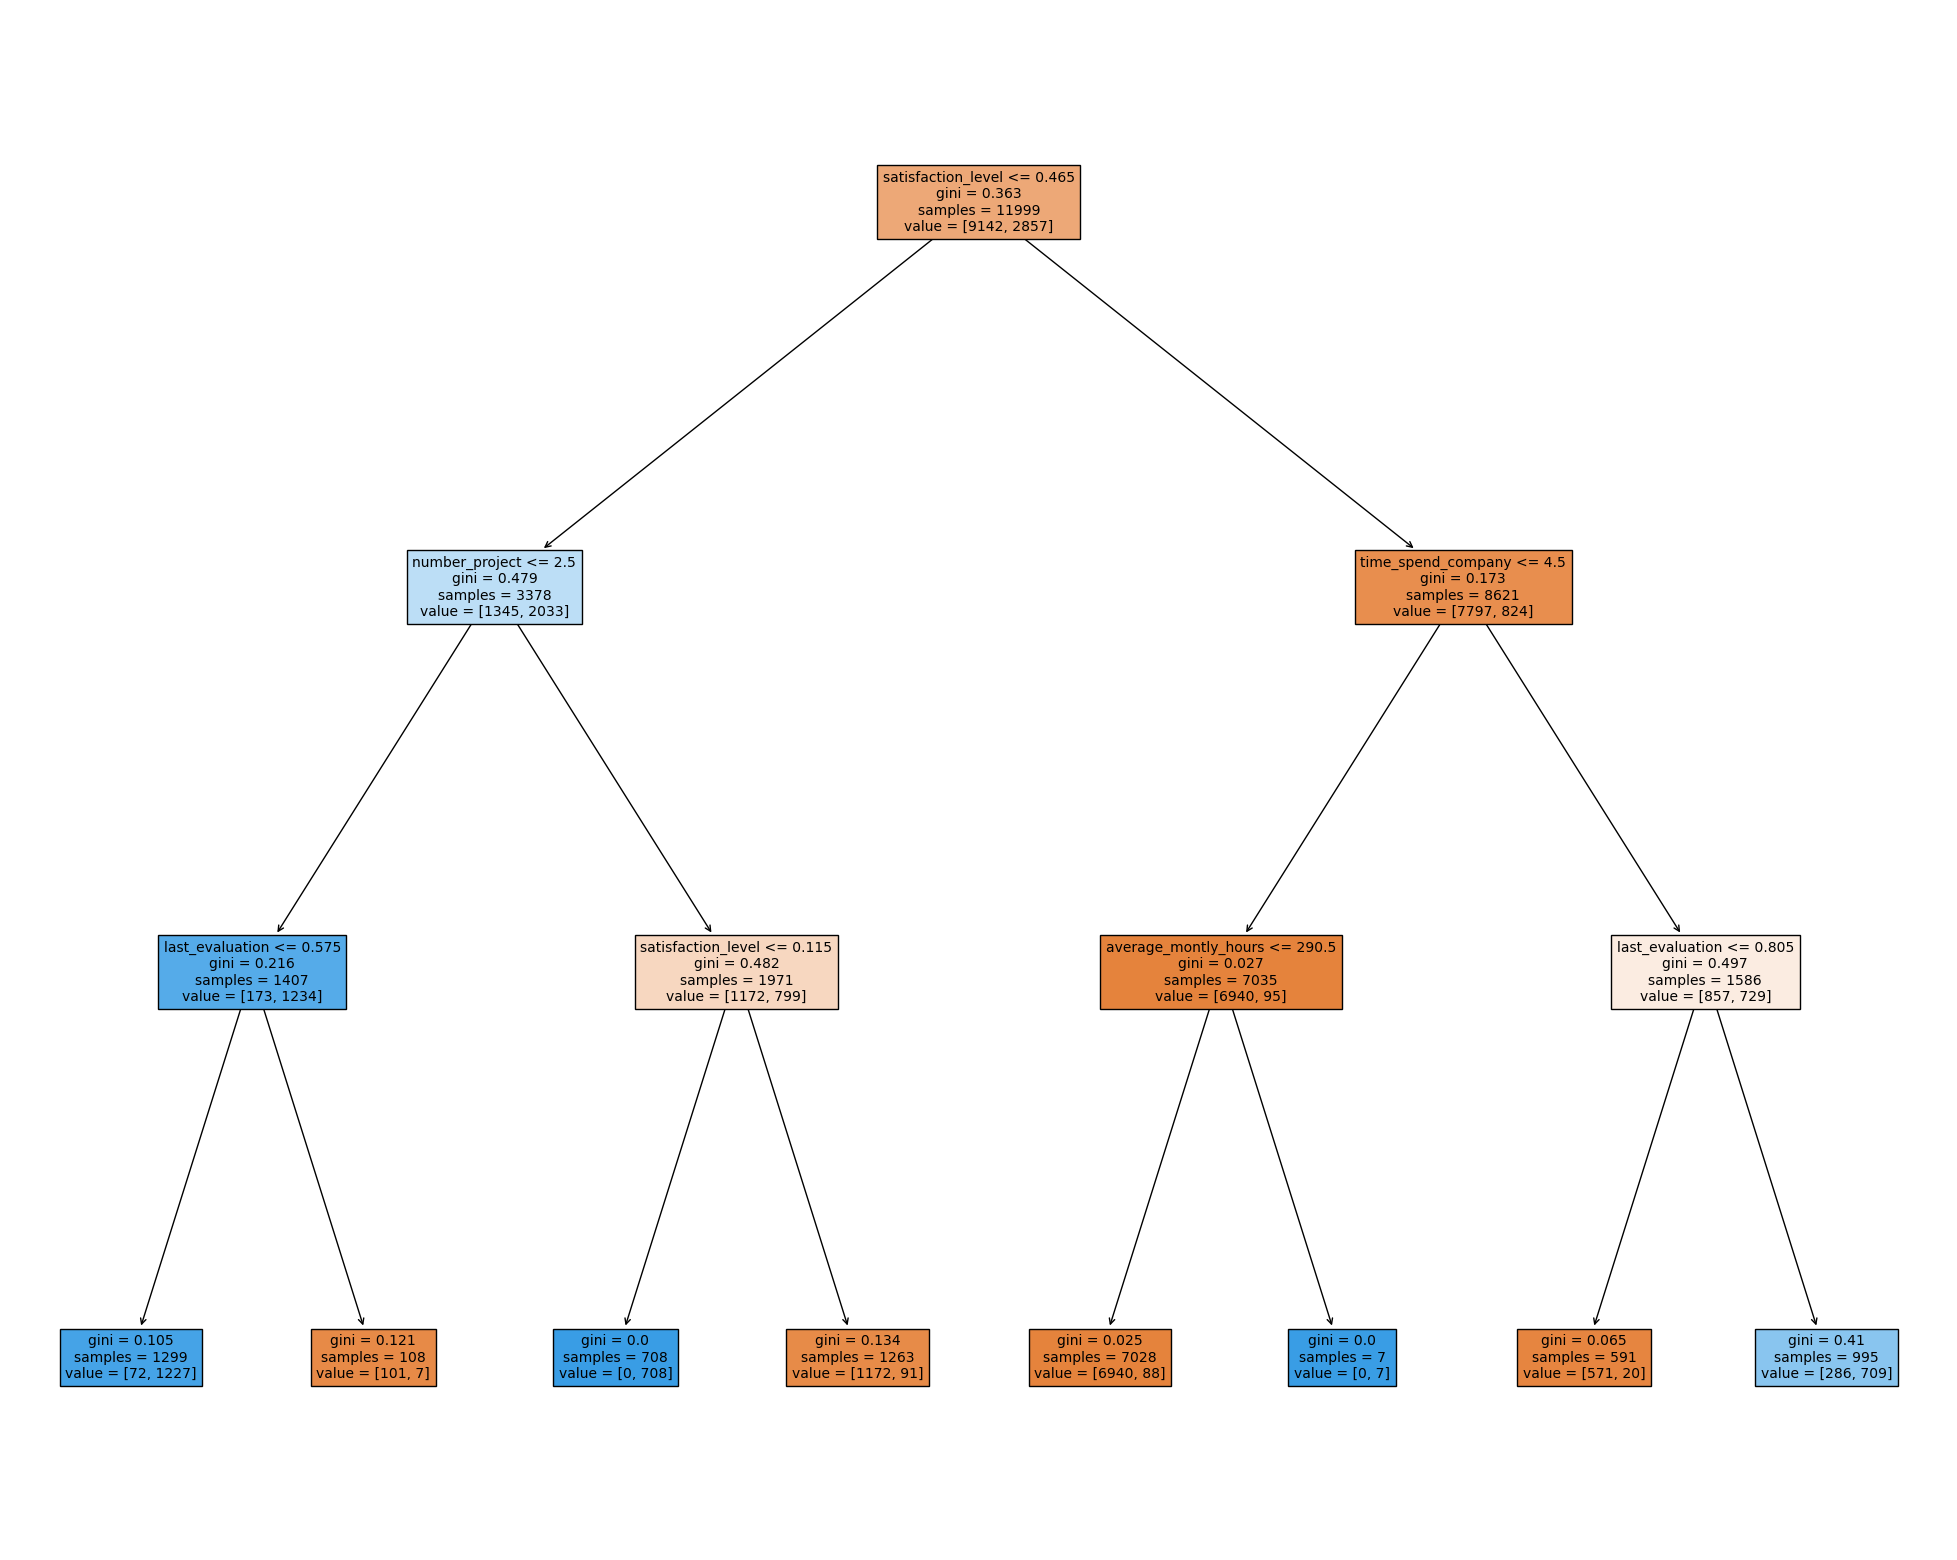

In [16]:
# defining imput and target
x = turnover.drop(columns = 'left', axis = 1)
y = turnover['left']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(0.25, 0.625, 'number_project <= 2.5\ngini = 0.478\nsamples = 3371\nvalue = [1334, 2037]'),
 Text(0.125, 0.375, 'last_evaluation <= 0.575\ngini = 0.222\nsamples = 1410\nvalue = [179, 1231]'),
 Text(0.0625, 0.125, 'gini = 0.111\nsamples = 1300\nvalue = [77, 1223]'),
 Text(0.1875, 0.125, 'gini = 0.135\nsamples = 110\nvalue = [102, 8]'),
 Text(0.375, 0.375, 'satisfaction_level <= 0.115\ngini = 0.484\nsamples = 1961\nvalue = [1155, 806]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 713\nvalue = [0, 713]'),
 Text(0.4375, 0.125, 'gini = 0.138\nsamples = 1248\nvalue = [1155, 93]'),
 Text(0.75, 0.625, 'time_spend_company <= 4.5\ngini = 0.172\nsamples = 8628\nvalue = [7808, 820]'),
 Text(0.625, 0.375, 'average_montly_hours <= 290.5\ngini = 0.029\nsamples = 7054\nvalue = [6950, 104]'),
 Text(0.5625, 0.125, 'gini = 0.027\nsamples = 7047\nvalue = [6950, 97]'),
 Text(0.6875, 0.125, 'gini = 0

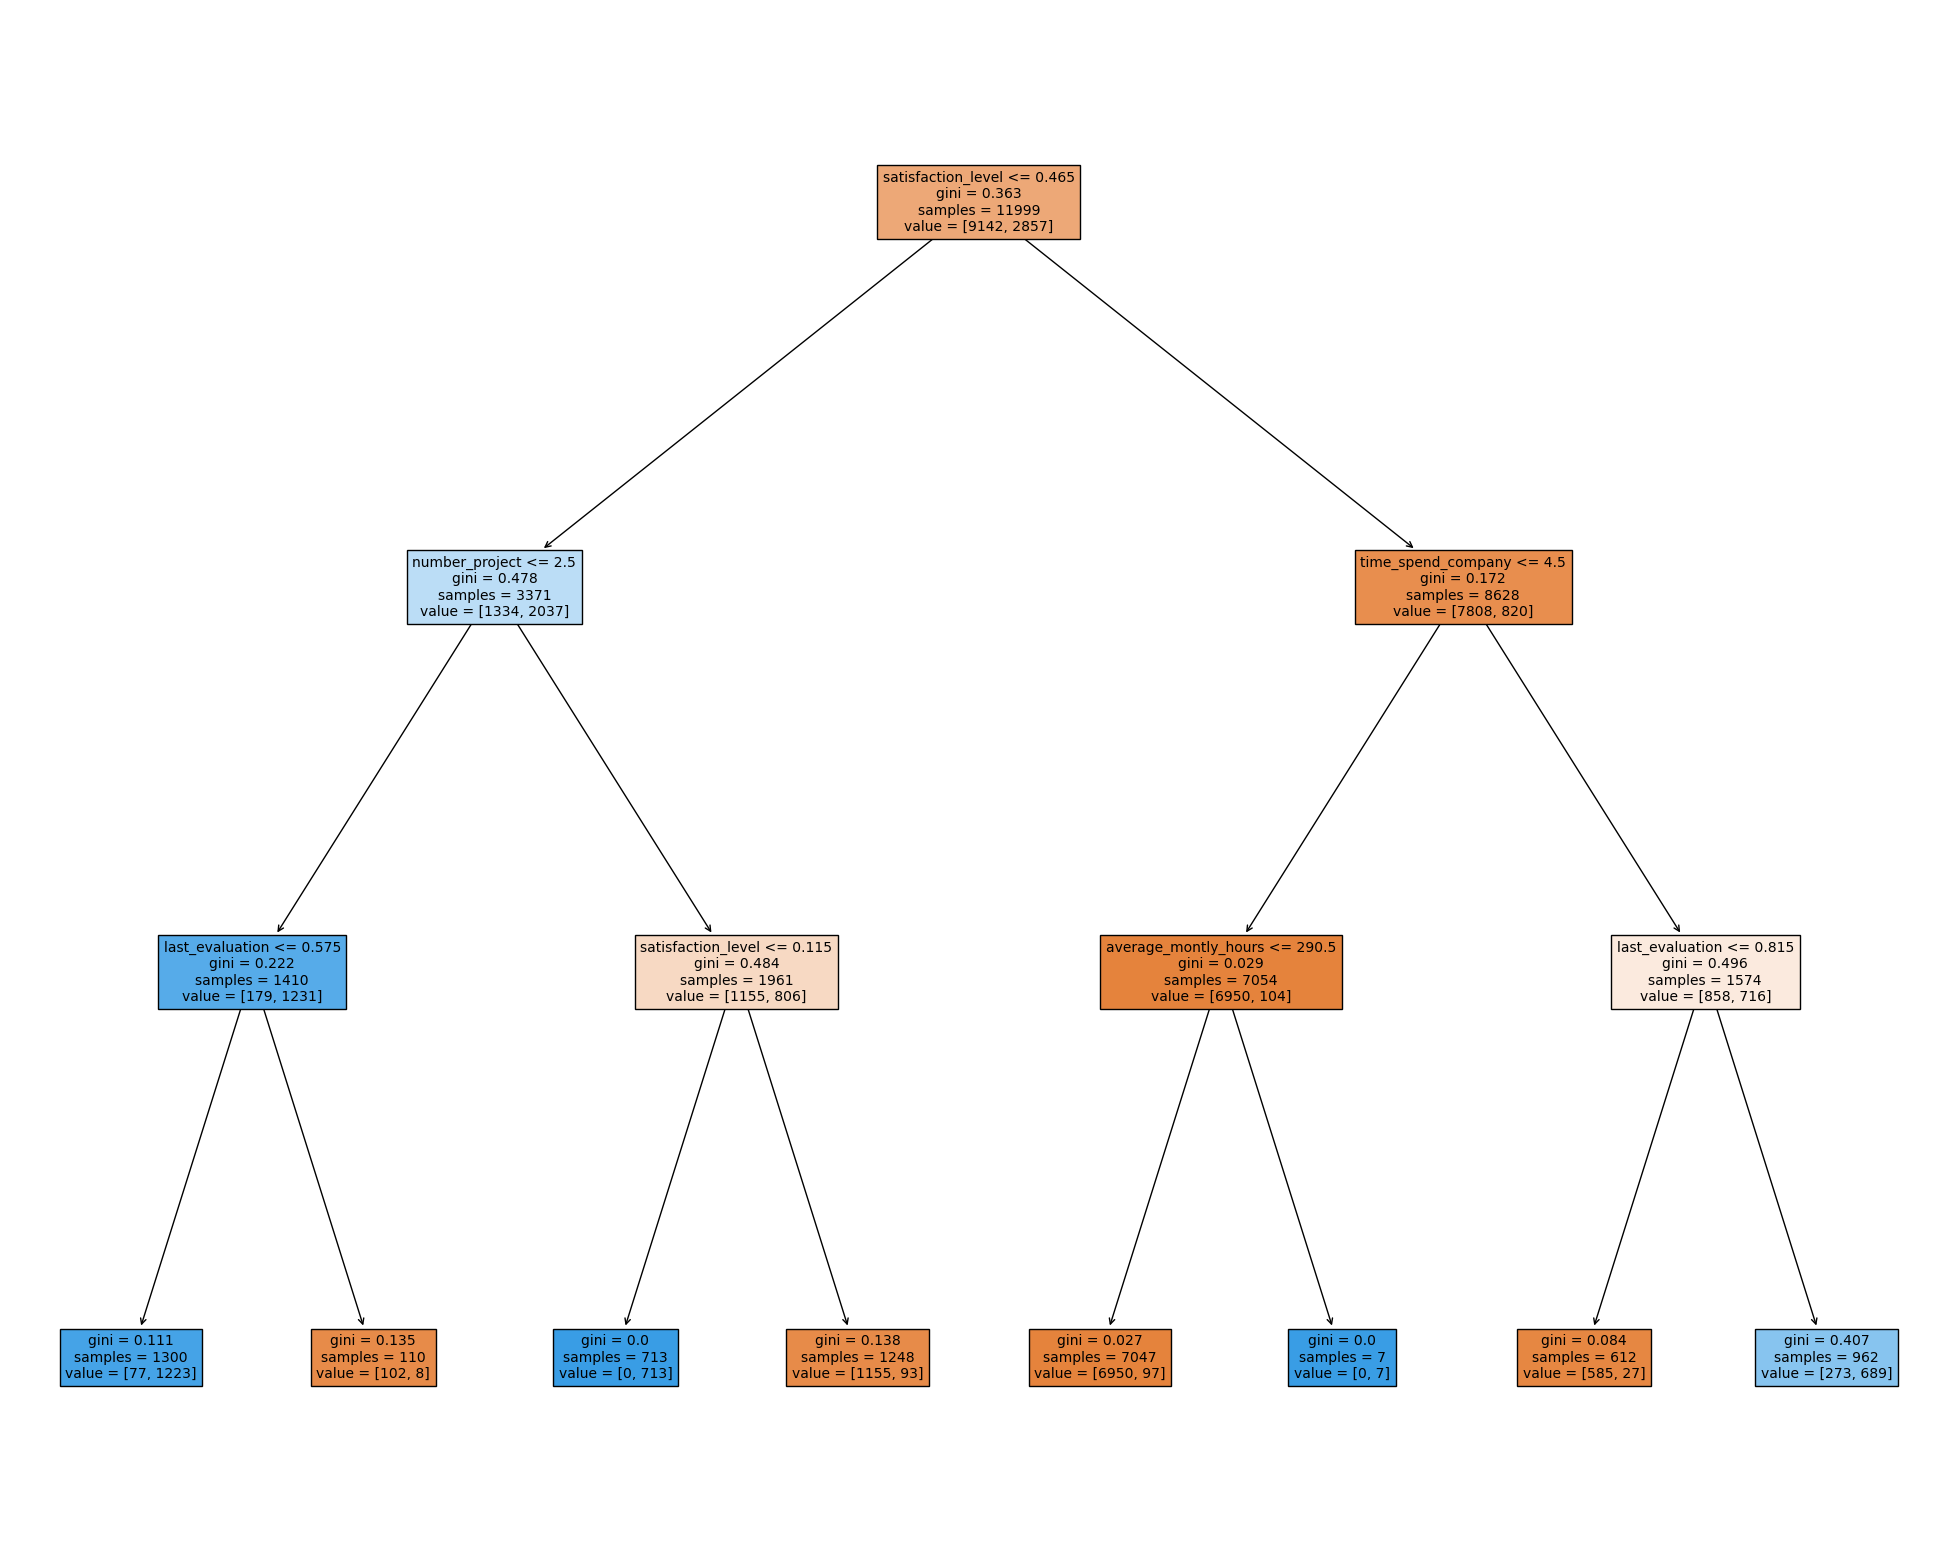

In [17]:
# defining imput and target
x = turnover.drop(columns = 'left', axis = 1)
y = turnover['left']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# building decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

In [21]:
# engineering interactions
turnover['interaction_1'] = np.where((turnover['satisfaction_level'] >= .115) & (turnover['satisfaction_level'] <= .465) & (turnover['number_project'] > 2.5), 1, 0)
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] <= .465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= .575), 1, 0)
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] > .465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)